## ИМПОРТ БИБЛИОТЕК И ЗАГРУЗКА ДАННЫХ

In [1]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Настройки отображения
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 200)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Загрузка данных
print("=" * 80)
print("ЗАГРУЗКА ДАННЫХ")
print("=" * 80)

try:
    user_evaluations = pd.read_csv('goodbooks-10k/ratings.csv')
    book_catalog = pd.read_csv('goodbooks-10k/books.csv')
    tag_definitions = pd.read_csv('goodbooks-10k/tags.csv')
    book_tags = pd.read_csv('goodbooks-10k/book_tags.csv')
    
    print("✓ Данные успешно загружены")
    print(f"  • Оценки пользователей: {user_evaluations.shape}")
    print(f"  • Каталог книг: {book_catalog.shape}")
    print(f"  • Определения тегов: {tag_definitions.shape}")
    print(f"  • Теги книг: {book_tags.shape}")
    
except FileNotFoundError as e:
    print(f"✗ Ошибка загрузки файлов: {e}")
    print("Проверьте наличие файлов в папке goodbooks-10k:")
    print("  1. ratings.csv")
    print("  2. books.csv")
    print("  3. tags.csv")
    print("  4. book_tags.csv")
    raise

ЗАГРУЗКА ДАННЫХ
✓ Данные успешно загружены
  • Оценки пользователей: (981756, 3)
  • Каталог книг: (10000, 23)
  • Определения тегов: (34252, 2)
  • Теги книг: (999912, 3)


## ЭТАП 1: ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ ДАННЫХ


ЭТАП 1: ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ ДАННЫХ

1. ОЦЕНКИ ПОЛЬЗОВАТЕЛЕЙ
----------------------------------------
Всего записей: 981,756
Уникальных пользователей: 53,424
Уникальных книг в оценках: 10,000
Диапазон оценок: от 1 до 5

Распределение оценок:
  1 звёзд: 19,575 (2.0%)
  2 звёзд: 63,231 (6.4%)
  3 звёзд: 248,623 (25.3%)
  4 звёзд: 357,366 (36.4%)
  5 звёзд: 292,961 (29.8%)


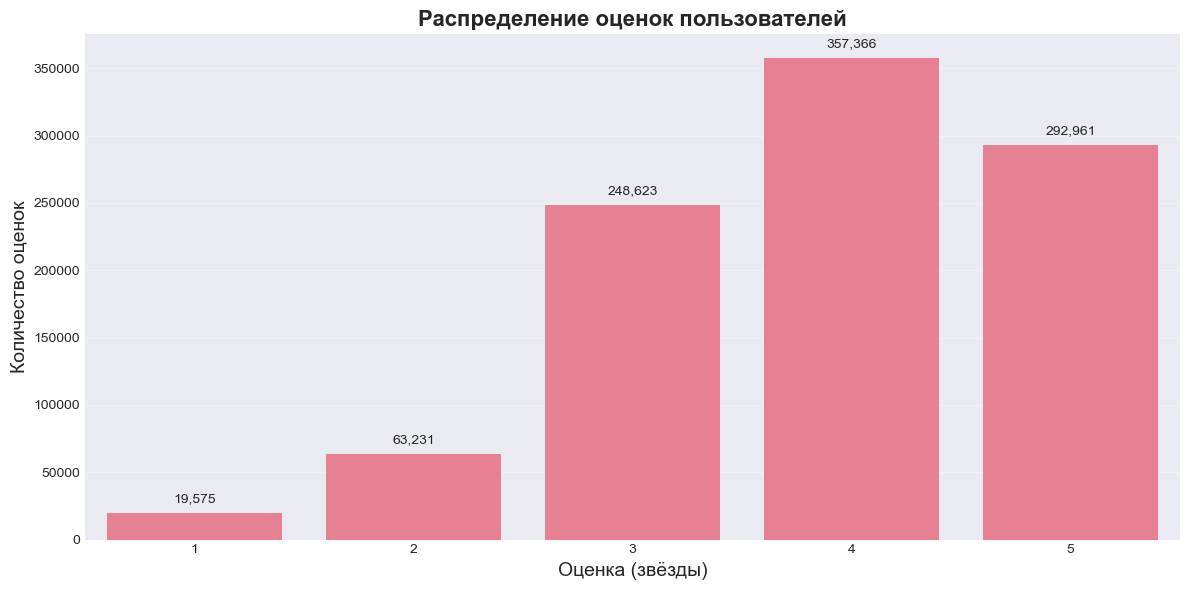

In [2]:
# === ЭТАП 1: ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ ДАННЫХ ===
print("\n" + "=" * 80)
print("ЭТАП 1: ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ ДАННЫХ")
print("=" * 80)

# 1.1 Анализ оценок пользователей
print("\n1. ОЦЕНКИ ПОЛЬЗОВАТЕЛЕЙ")
print("-" * 40)

print(f"Всего записей: {user_evaluations.shape[0]:,}")
print(f"Уникальных пользователей: {user_evaluations['user_id'].nunique():,}")
print(f"Уникальных книг в оценках: {user_evaluations['book_id'].nunique():,}")
print(f"Диапазон оценок: от {user_evaluations['rating'].min()} до {user_evaluations['rating'].max()}")

# Распределение оценок
rating_stats = user_evaluations['rating'].value_counts().sort_index()
print("\nРаспределение оценок:")
for rating, count in rating_stats.items():
    percentage = (count / len(user_evaluations)) * 100
    print(f"  {rating} звёзд: {count:,} ({percentage:.1f}%)")

# Визуализация распределения оценок
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=user_evaluations, x='rating', order=sorted(user_evaluations['rating'].unique()))
plt.title('Распределение оценок пользователей', fontsize=16, fontweight='bold')
plt.xlabel('Оценка (звёзды)', fontsize=14)
plt.ylabel('Количество оценок', fontsize=14)

# Добавление значений на столбцы
for p in ax.patches:
    ax.annotate(f'{int(p.get_height()):,}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize=10)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 1.2 АКТИВНОСТЬ ПОЛЬЗОВАТЕЛЕЙ


2. АКТИВНОСТЬ ПОЛЬЗОВАТЕЛЕЙ
----------------------------------------
Среднее количество оценок на пользователя: 18.4
Медианное количество оценок: 8
Средняя оценка пользователей: 3.88
Самый активный пользователь оценил 200 книг


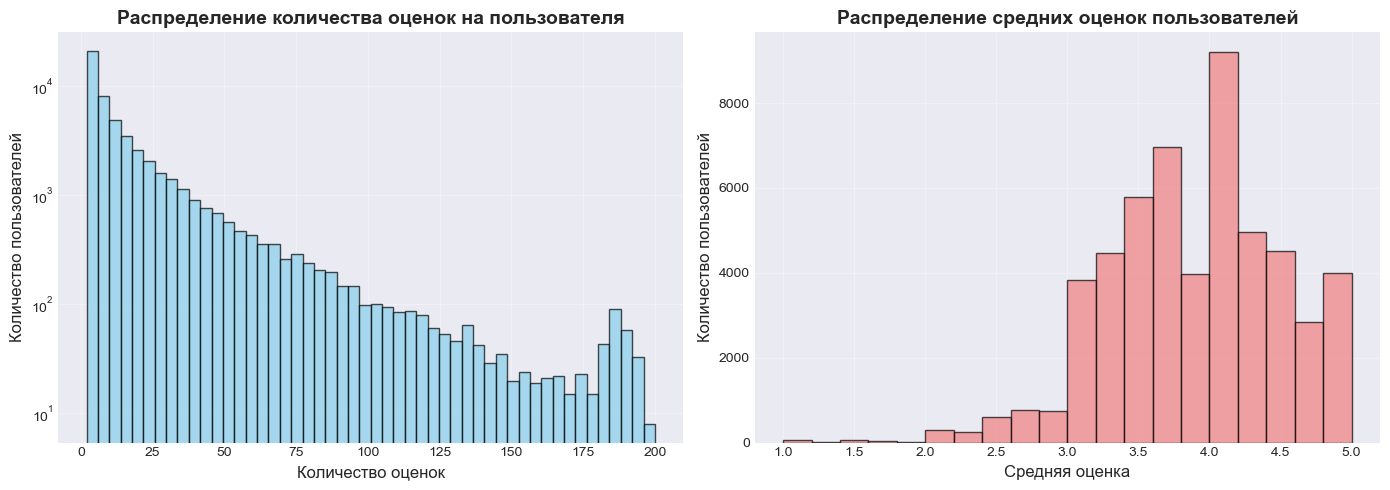

In [3]:
# 1.2 Анализ активности пользователей
print("\n2. АКТИВНОСТЬ ПОЛЬЗОВАТЕЛЕЙ")
print("-" * 40)

user_activity = user_evaluations.groupby('user_id').agg(
    books_rated=('book_id', 'count'),
    avg_rating=('rating', 'mean')
).reset_index()

print(f"Среднее количество оценок на пользователя: {user_activity['books_rated'].mean():.1f}")
print(f"Медианное количество оценок: {user_activity['books_rated'].median():.0f}")
print(f"Средняя оценка пользователей: {user_activity['avg_rating'].mean():.2f}")
print(f"Самый активный пользователь оценил {user_activity['books_rated'].max()} книг")

# Визуализация активности пользователей
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Гистограмма количества оценок
axes[0].hist(user_activity['books_rated'], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].set_title('Распределение количества оценок на пользователя', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Количество оценок', fontsize=12)
axes[0].set_ylabel('Количество пользователей', fontsize=12)
axes[0].set_yscale('log')
axes[0].grid(alpha=0.3)

# Гистограмма средних оценок
axes[1].hist(user_activity['avg_rating'], bins=20, edgecolor='black', alpha=0.7, color='lightcoral')
axes[1].set_title('Распределение средних оценок пользователей', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Средняя оценка', fontsize=12)
axes[1].set_ylabel('Количество пользователей', fontsize=12)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 1.3 Анализ данных о книгах


3. АНАЛИЗ КАТАЛОГА КНИГ
----------------------------------------
Всего книг в каталоге: 10,000
Количество столбцов: 23

Пропущенные значения:
  isbn: 700 (7.0%)
  isbn13: 585 (5.9%)
  original_publication_year: 21 (0.2%)
  original_title: 585 (5.9%)
  language_code: 1,084 (10.8%)

Заполнено 0 пропусков в original_title

Основные статистики книг:

books_count:
  Среднее: 75.71
  Медиана: 40.00
  Мин: 1.00
  Макс: 3455.00

average_rating:
  Среднее: 4.00
  Медиана: 4.02
  Мин: 2.47
  Макс: 4.82

ratings_count:
  Среднее: 54001.24
  Медиана: 21155.50
  Мин: 2716.00
  Макс: 4780653.00


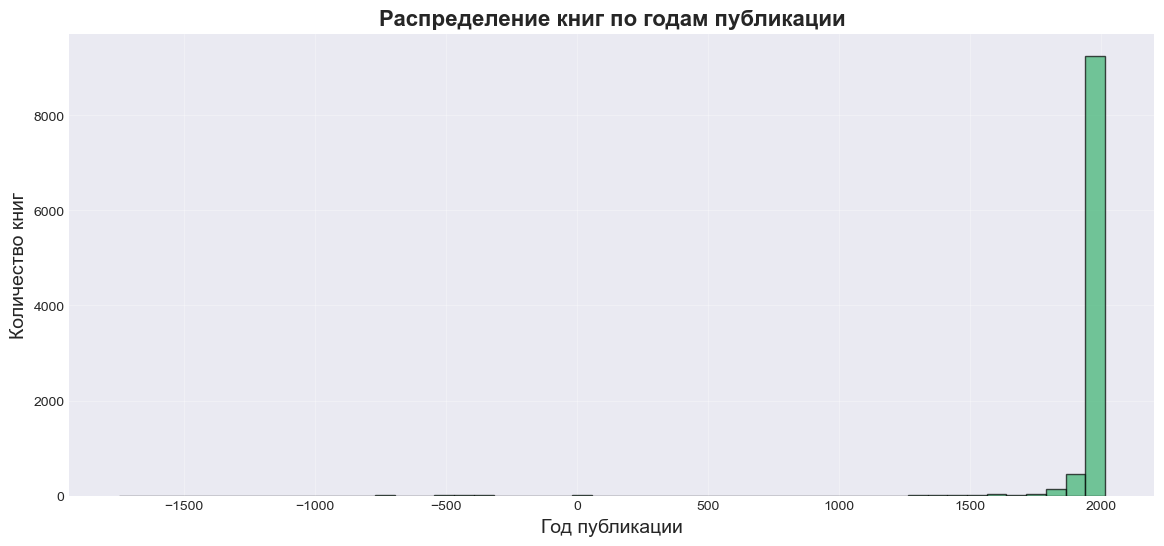


ТОП-10 книг по количеству оценок:
                                                       title                      authors  ratings_count  average_rating
1                    The Hunger Games (The Hunger Games, #1)              Suzanne Collins        4780653            4.34
2   Harry Potter and the Sorcerer's Stone (Harry Potter, #1)  J.K. Rowling, Mary GrandPré        4602479            4.44
3                                    Twilight (Twilight, #1)              Stephenie Meyer        3866839            3.57
4                                      To Kill a Mockingbird                   Harper Lee        3198671            4.25
5                                           The Great Gatsby          F. Scott Fitzgerald        2683664            3.89
6                                     The Fault in Our Stars                   John Green        2346404            4.26
7                                                 The Hobbit               J.R.R. Tolkien        2071616            4.

In [4]:
# 1.3 Анализ данных о книгах
print("\n3. АНАЛИЗ КАТАЛОГА КНИГ")
print("-" * 40)

# Основная информация
print(f"Всего книг в каталоге: {book_catalog.shape[0]:,}")
print(f"Количество столбцов: {book_catalog.shape[1]}")

# Проверка и обработка пропущенных значений
missing_data = book_catalog.isnull().sum()
print("\nПропущенные значения:")
for column, missing_count in missing_data[missing_data > 0].items():
    percentage = (missing_count / len(book_catalog)) * 100
    print(f"  {column}: {missing_count:,} ({percentage:.1f}%)")

# Заполнение пропусков
book_catalog['original_title'] = book_catalog['original_title'].fillna(book_catalog['title'])
print(f"\nЗаполнено {book_catalog['original_title'].isnull().sum()} пропусков в original_title")

# Основные статистики
print("\nОсновные статистики книг:")
stats_summary = {
    'books_count': book_catalog['books_count'].describe(),
    'average_rating': book_catalog['average_rating'].describe(),
    'ratings_count': book_catalog['ratings_count'].describe()
}

for stat_name, stat_values in stats_summary.items():
    print(f"\n{stat_name}:")
    print(f"  Среднее: {stat_values['mean']:.2f}")
    print(f"  Медиана: {stat_values['50%']:.2f}")
    print(f"  Мин: {stat_values['min']:.2f}")
    print(f"  Макс: {stat_values['max']:.2f}")

# Анализ годов публикации
plt.figure(figsize=(14, 6))
valid_years = book_catalog['original_publication_year'].dropna()
plt.hist(valid_years, bins=50, edgecolor='black', alpha=0.7, color='mediumseagreen')
plt.title('Распределение книг по годам публикации', fontsize=16, fontweight='bold')
plt.xlabel('Год публикации', fontsize=14)
plt.ylabel('Количество книг', fontsize=14)
plt.grid(alpha=0.3)
plt.show()

# Топ-10 самых популярных книг
print("\nТОП-10 книг по количеству оценок:")
top_books = book_catalog.nlargest(10, 'ratings_count')[['title', 'authors', 'ratings_count', 'average_rating']]
top_books.index = range(1, 11)
print(top_books.to_string())

## 1.4 Анализ тегов и категорий


4. АНАЛИЗ ТЕГОВ И КАТЕГОРИЙ
----------------------------------------
Всего уникальных тегов: 34,252
Всего присвоений тегов книгам: 999,912

ТОП-20 самых популярных тегов:
 1. to-read                                  (140,718,761)
 2. currently-reading                        (7,507,958)
 3. favorites                                (4,503,173)
 4. fiction                                  (3,688,819)
 5. fantasy                                  (3,548,157)
 6. young-adult                              (1,848,306)
 7. classics                                 (1,756,920)
 8. books-i-own                              (1,317,235)
 9. romance                                  (1,231,926)
10. owned                                    (1,224,279)
11. ya                                       (898,334)
12. mystery                                  (872,282)
13. non-fiction                              (857,901)
14. historical-fiction                       (815,421)
15. series                          

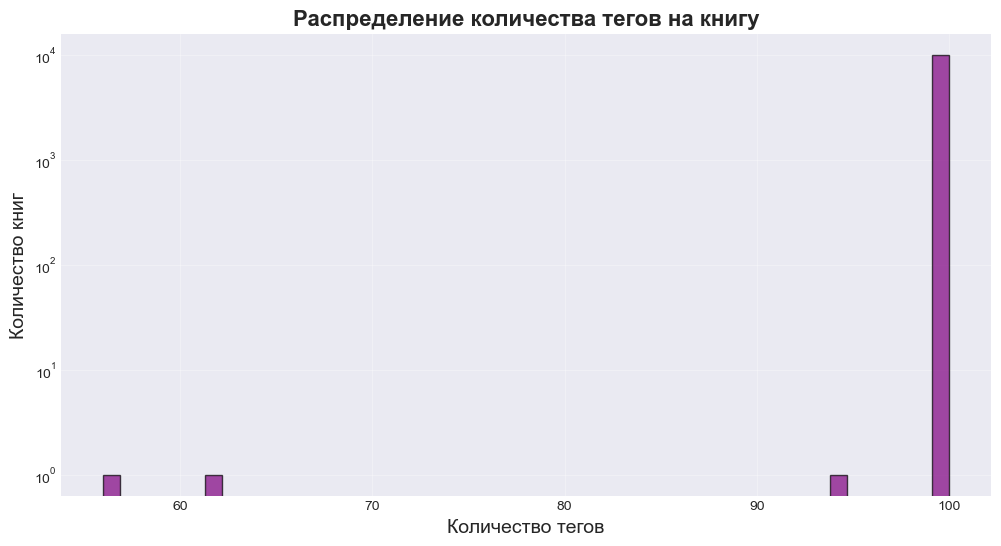

In [5]:
# 1.4 Анализ тегов и категорий
print("\n4. АНАЛИЗ ТЕГОВ И КАТЕГОРИЙ")
print("-" * 40)

print(f"Всего уникальных тегов: {tag_definitions.shape[0]:,}")
print(f"Всего присвоений тегов книгам: {book_tags.shape[0]:,}")

# Самые популярные теги
top_tags = book_tags.groupby('tag_id')['count'].sum().sort_values(ascending=False).head(20)
top_tags_df = pd.DataFrame({
    'tag_id': top_tags.index,
    'total_count': top_tags.values
}).merge(tag_definitions[['tag_id', 'tag_name']], on='tag_id')

print("\nТОП-20 самых популярных тегов:")
for i, row in top_tags_df.iterrows():
    print(f"{i+1:2d}. {row['tag_name'][:40]:40} ({row['total_count']:,})")

# Распределение тегов по книгам
tags_per_book = book_tags.groupby('goodreads_book_id').size()
print(f"\nСреднее количество тегов на книгу: {tags_per_book.mean():.1f}")
print(f"Медианное количество тегов: {tags_per_book.median():.0f}")
print(f"Максимальное количество тегов у книги: {tags_per_book.max()}")

# Визуализация распределения тегов
plt.figure(figsize=(12, 6))
plt.hist(tags_per_book, bins=50, edgecolor='black', alpha=0.7, color='purple')
plt.title('Распределение количества тегов на книгу', fontsize=16, fontweight='bold')
plt.xlabel('Количество тегов', fontsize=14)
plt.ylabel('Количество книг', fontsize=14)
plt.grid(alpha=0.3)
plt.yscale('log')
plt.show()

## 1.5 Проверка целостности данных

In [6]:
# 1.5 Проверка целостности данных
print("\n5. ПРОВЕРКА ЦЕЛОСТНОСТИ ДАННЫХ")
print("-" * 40)

print("Проверка связей между таблицами:")
print("-" * 30)

# Преобразование типов для корректного сравнения
book_catalog['id_str'] = book_catalog['id'].astype(str)
book_catalog['book_id_str'] = book_catalog['book_id'].astype(str)
user_evaluations['book_id_str'] = user_evaluations['book_id'].astype(str)
book_tags['goodreads_book_id_str'] = book_tags['goodreads_book_id'].astype(str)

# 1. Оценки ↔ Книги (по book_id)
common_book_ids = set(user_evaluations['book_id_str']).intersection(set(book_catalog['book_id_str']))
print(f"1. Общие book_id (оценки↔книги): {len(common_book_ids):,}")
print(f"   • Книг с оценками: {user_evaluations['book_id'].nunique():,}")
print(f"   • Всего книг в каталоге: {book_catalog['book_id'].nunique():,}")

# 2. Теги книг ↔ Книги (по goodreads_book_id)
common_goodreads = set(book_tags['goodreads_book_id_str']).intersection(set(book_catalog['id_str']))
print(f"\n2. Общие goodreads_book_id (теги↔книги): {len(common_goodreads):,}")
print(f"   • Книг с тегами: {book_tags['goodreads_book_id'].nunique():,}")
print(f"   • Всего книг в каталоге: {book_catalog['id'].nunique():,}")

# 3. Теги книг ↔ Определения тегов
common_tags = set(book_tags['tag_id']).intersection(set(tag_definitions['tag_id']))
print(f"\n3. Общие tag_id (теги↔определения): {len(common_tags):,}")
print(f"   • Используемых тегов: {book_tags['tag_id'].nunique():,}")
print(f"   • Всего определений тегов: {tag_definitions.shape[0]:,}")

# Анализ полноты данных
print("\nАНАЛИЗ ПОЛНОТЫ ДАННЫХ:")
print("-" * 30)

# Книги с оценками
books_with_ratings = book_catalog[book_catalog['book_id_str'].isin(common_book_ids)]
print(f"• Книг с оценками: {len(books_with_ratings):,} ({len(books_with_ratings)/len(book_catalog)*100:.1f}%)")

# Книги с тегами
books_with_tags = book_catalog[book_catalog['id_str'].isin(common_goodreads)]
print(f"• Книг с тегами: {len(books_with_tags):,} ({len(books_with_tags)/len(book_catalog)*100:.1f}%)")

# Книги с полной информацией
complete_books = book_catalog[
    book_catalog['book_id_str'].isin(common_book_ids) & 
    book_catalog['id_str'].isin(common_goodreads)
]
print(f"• Книг с полной информацией: {len(complete_books):,} ({len(complete_books)/len(book_catalog)*100:.1f}%)")

# Создание основного датасета для рекомендаций
print("\nСоздание основного датасета для рекомендаций...")

# Сначала создадим агрегированные данные по оценкам
book_ratings_agg = user_evaluations.groupby('book_id').agg(
    user_avg_rating=('rating', 'mean'),
    user_rating_count=('rating', 'count')
).reset_index()

# Объединяем с информацией о книгах
books_main = book_catalog.merge(
    book_ratings_agg,
    left_on='book_id',
    right_on='book_id',
    how='left'
)

print(f"Основной датасет создан: {books_main.shape}")
print(f"Книг с оценками пользователей: {books_main['user_avg_rating'].notna().sum():,}")


5. ПРОВЕРКА ЦЕЛОСТНОСТИ ДАННЫХ
----------------------------------------
Проверка связей между таблицами:
------------------------------
1. Общие book_id (оценки↔книги): 812
   • Книг с оценками: 10,000
   • Всего книг в каталоге: 10,000

2. Общие goodreads_book_id (теги↔книги): 812
   • Книг с тегами: 10,000
   • Всего книг в каталоге: 10,000

3. Общие tag_id (теги↔определения): 34,252
   • Используемых тегов: 34,252
   • Всего определений тегов: 34,252

АНАЛИЗ ПОЛНОТЫ ДАННЫХ:
------------------------------
• Книг с оценками: 812 (8.1%)
• Книг с тегами: 812 (8.1%)
• Книг с полной информацией: 77 (0.8%)

Создание основного датасета для рекомендаций...
Основной датасет создан: (10000, 27)
Книг с оценками пользователей: 812


## === ЭТАП 2: РЕКОМЕНДАТЕЛЬНЫЕ СИСТЕМЫ ===

In [7]:
# === ЭТАП 2: РЕКОМЕНДАТЕЛЬНЫЕ СИСТЕМЫ ===
print("\n" + "=" * 80)
print("ЭТАП 2: РЕКОМЕНДАТЕЛЬНЫЕ СИСТЕМЫ")
print("=" * 80)

# 2.1 Рекомендации на основе популярности
print("\n1. СИСТЕМА РЕКОМЕНДАЦИЙ НА ОСНОВЕ ПОПУЛЯРНОСТИ")
print("-" * 40)

def get_popular_recommendations(n=10, min_ratings=100):
    """
    Рекомендует популярные книги на основе рейтинга и количества оценок
    """
    # Фильтруем книги с минимальным количеством оценок
    popular_books = books_main[books_main['ratings_count'] >= min_ratings].copy()
    
    if len(popular_books) < n:
        print(f"⚠ Недостаточно книг с {min_ratings}+ оценками")
        popular_books = books_main.copy()
    
    # Создаем комбинированный показатель популярности
    # Используем 60% веса для рейтинга и 40% для количества оценок
    rating_min = popular_books['average_rating'].min()
    rating_max = popular_books['average_rating'].max()
    count_min = popular_books['ratings_count'].min()
    count_max = popular_books['ratings_count'].max()
    
    popular_books['norm_rating'] = (popular_books['average_rating'] - rating_min) / (rating_max - rating_min)
    popular_books['norm_count'] = (popular_books['ratings_count'] - count_min) / (count_max - count_min)
    popular_books['popularity_score'] = 0.6 * popular_books['norm_rating'] + 0.4 * popular_books['norm_count']
    
    # Сортируем по популярности
    recommendations = popular_books.sort_values('popularity_score', ascending=False).head(n)
    
    return recommendations[['title', 'authors', 'average_rating', 'ratings_count', 'popularity_score']]

# Тестируем рекомендации
print("ТОП-10 популярных книг (минимум 100 оценок):")
popular_recs = get_popular_recommendations(10, 100)
for i, (_, row) in enumerate(popular_recs.iterrows(), 1):
    print(f"{i:2d}. {row['title'][:50]:50} | Автор: {row['authors'][:30]:30} | "
          f"Рейтинг: {row['average_rating']:.2f} | Оценок: {row['ratings_count']:,}")


ЭТАП 2: РЕКОМЕНДАТЕЛЬНЫЕ СИСТЕМЫ

1. СИСТЕМА РЕКОМЕНДАЦИЙ НА ОСНОВЕ ПОПУЛЯРНОСТИ
----------------------------------------
ТОП-10 популярных книг (минимум 100 оценок):
 1. Harry Potter and the Sorcerer's Stone (Harry Potte | Автор: J.K. Rowling, Mary GrandPré    | Рейтинг: 4.44 | Оценок: 4,602,479
 2. The Hunger Games (The Hunger Games, #1)            | Автор: Suzanne Collins                | Рейтинг: 4.34 | Оценок: 4,780,653
 3. To Kill a Mockingbird                              | Автор: Harper Lee                     | Рейтинг: 4.25 | Оценок: 3,198,671
 4. Harry Potter and the Deathly Hallows (Harry Potter | Автор: J.K. Rowling, Mary GrandPré    | Рейтинг: 4.61 | Оценок: 1,746,574
 5. Harry Potter and the Prisoner of Azkaban (Harry Po | Автор: J.K. Rowling, Mary GrandPré, R | Рейтинг: 4.53 | Оценок: 1,832,823
 6. Harry Potter and the Goblet of Fire (Harry Potter, | Автор: J.K. Rowling, Mary GrandPré    | Рейтинг: 4.53 | Оценок: 1,753,043
 7. Harry Potter and the Half-Blood Prince (Ha

## 2.2 Рекомендации на основе контента (по авторам и тегам)

In [8]:
# 2.2 Рекомендации на основе контента (по авторам и тегам)
print("\n2. РЕКОМЕНДАЦИИ НА ОСНОВЕ КОНТЕНТА")
print("-" * 40)

def prepare_content_features():
    """Подготавливает данные для контентных рекомендаций"""
    # Объединяем теги книг с названиями тегов
    book_tag_names = book_tags.merge(
        tag_definitions[['tag_id', 'tag_name']],
        on='tag_id',
        how='left'
    )
    
    # Группируем теги по книгам
    book_tags_grouped = book_tag_names.groupby('goodreads_book_id_str').agg({
        'tag_name': lambda x: ' '.join(x.dropna().astype(str))
    }).reset_index()
    
    # Объединяем с книгами
    books_content = book_catalog.copy()
    books_content['goodreads_book_id_str'] = books_content['id'].astype(str)
    
    content_data = books_content.merge(
        book_tags_grouped,
        left_on='goodreads_book_id_str',
        right_on='goodreads_book_id_str',
        how='left'
    )
    
    # Заполняем пропуски
    content_data['tag_name'] = content_data['tag_name'].fillna('')
    
    # Создаем текстовые признаки (авторы + теги)
    content_data['content_features'] = content_data['authors'] + ' ' + content_data['tag_name']
    
    return content_data

def get_content_recommendations(book_title, n=5):
    """Рекомендует книги, похожие на заданную"""
    # Подготавливаем данные
    content_data = prepare_content_features()
    
    # Находим книгу
    book_idx = content_data[content_data['title'].str.contains(book_title, case=False, na=False)].index
    
    if len(book_idx) == 0:
        print(f"Книга '{book_title}' не найдена")
        return None
    
    book_idx = book_idx[0]
    book_info = content_data.iloc[book_idx]
    
    print(f"Ищем книги, похожие на: '{book_info['title']}'")
    print(f"Автор: {book_info['authors']}")
    
    # Векторизуем текст
    vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
    tfidf_matrix = vectorizer.fit_transform(content_data['content_features'])
    
    # Вычисляем схожесть
    cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
    
    # Получаем рекомендации
    sim_scores = list(enumerate(cosine_sim[book_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Пропускаем саму книгу
    sim_scores = sim_scores[1:n+1]
    
    # Формируем рекомендации
    recommendations = []
    for idx, score in sim_scores:
        book = content_data.iloc[idx]
        recommendations.append({
            'title': book['title'],
            'authors': book['authors'],
            'similarity_score': score,
            'average_rating': book['average_rating']
        })
    
    return pd.DataFrame(recommendations)

# Тестируем контентные рекомендации
test_book = "Harry Potter"
print(f"\nТестируем рекомендации для книг, содержащих '{test_book}':")

content_recs = get_content_recommendations(test_book, 5)
if content_recs is not None:
    for i, row in content_recs.iterrows():
        print(f"{i+1:2d}. {row['title'][:50]:50} | "
              f"Схожесть: {row['similarity_score']:.3f} | "
              f"Рейтинг: {row['average_rating']:.2f}")


2. РЕКОМЕНДАЦИИ НА ОСНОВЕ КОНТЕНТА
----------------------------------------

Тестируем рекомендации для книг, содержащих 'Harry Potter':
Ищем книги, похожие на: 'Harry Potter and the Sorcerer's Stone (Harry Potter, #1)'
Автор: J.K. Rowling, Mary GrandPré
 1. The Hunger Games (The Hunger Games, #1)            | Схожесть: 0.889 | Рейтинг: 4.34
 2. The Fault in Our Stars                             | Схожесть: 0.879 | Рейтинг: 4.26
 3. The Great Gatsby                                   | Схожесть: 0.870 | Рейтинг: 3.89
 4. Twilight (Twilight, #1)                            | Схожесть: 0.865 | Рейтинг: 3.57
 5. Pride and Prejudice                                | Схожесть: 0.837 | Рейтинг: 4.24


## 2.3 Коллаборативная фильтрация

In [9]:
# 2.3 Коллаборативная фильтрация
print("\n3. КОЛЛАБОРАТИВНАЯ ФИЛЬТРАЦИЯ")
print("-" * 40)

def prepare_collaborative_data():
    """Подготавливает данные для коллаборативной фильтрации"""
    # Создаем разреженную матрицу пользователь-книга
    user_book_matrix = user_evaluations.pivot_table(
        index='user_id',
        columns='book_id',
        values='rating'
    ).fillna(0)
    
    return user_book_matrix

def collaborative_filtering_recommendations(user_id, n=10):
    """Рекомендует книги с помощью коллаборативной фильтрации"""
    try:
        # Подготавливаем данные
        user_book_matrix = prepare_collaborative_data()
        
        if user_id not in user_book_matrix.index:
            print(f"Пользователь {user_id} не найден")
            return None
        
        # Вычисляем схожесть пользователей
        user_similarity = cosine_similarity(user_book_matrix)
        user_similarity_df = pd.DataFrame(
            user_similarity,
            index=user_book_matrix.index,
            columns=user_book_matrix.index
        )
        
        # Находим похожих пользователей
        similar_users = user_similarity_df[user_id].sort_values(ascending=False)[1:11]
        
        # Получаем оценки похожих пользователей
        similar_users_ratings = user_book_matrix.loc[similar_users.index]
        
        # Взвешиваем оценки по схожести
        weighted_ratings = []
        for book_id in user_book_matrix.columns:
            ratings = similar_users_ratings[book_id]
            similarity_weights = similar_users.values
            
            # Учитываем только книги, которые пользователь не оценивал
            if user_book_matrix.loc[user_id, book_id] == 0:
                valid_mask = ratings > 0
                if valid_mask.any():
                    weighted_rating = np.dot(ratings[valid_mask], similarity_weights[valid_mask]) / similarity_weights[valid_mask].sum()
                    weighted_ratings.append((book_id, weighted_rating))
        
        # Сортируем по взвешенным оценкам
        weighted_ratings.sort(key=lambda x: x[1], reverse=True)
        
        # Получаем топ-N рекомендаций
        recommendations = []
        for book_id, score in weighted_ratings[:n]:
            book_info = books_main[books_main['book_id'] == book_id]
            if not book_info.empty:
                book = book_info.iloc[0]
                recommendations.append({
                    'book_id': book_id,
                    'title': book['title'],
                    'authors': book['authors'],
                    'predicted_rating': score,
                    'average_rating': book['average_rating']
                })
        
        return pd.DataFrame(recommendations)
        
    except Exception as e:
        print(f"Ошибка при формировании рекомендаций: {e}")
        return None

# Тестируем коллаборативную фильтрацию
print("Тестируем коллаборативную фильтрацию для пользователя 1:")

collab_recs = collaborative_filtering_recommendations(1, 5)
if collab_recs is not None:
    for i, row in collab_recs.iterrows():
        print(f"{i+1:2d}. {row['title'][:50]:50} | "
              f"Прогноз: {row['predicted_rating']:.2f} | "
              f"Общий рейтинг: {row['average_rating']:.2f}")


3. КОЛЛАБОРАТИВНАЯ ФИЛЬТРАЦИЯ
----------------------------------------
Тестируем коллаборативную фильтрацию для пользователя 1:
 1. V.                                                 | Прогноз: 5.00 | Общий рейтинг: 3.97


## 2.4 Гибридная рекомендательная система

In [10]:
# 2.4 Гибридная рекомендательная система
print("\n4. ГИБРИДНАЯ РЕКОМЕНДАТЕЛЬНАЯ СИСТЕМА")
print("-" * 40)

def hybrid_recommendations(user_id=None, book_title=None, n=10):
    """
    Гибридные рекомендации, сочетающие разные подходы
    """
    recommendations = []
    
    # 1. Если указан пользователь - используем коллаборативную фильтрацию
    if user_id is not None:
        collab_recs = collaborative_filtering_recommendations(user_id, n)
        if collab_recs is not None:
            for _, row in collab_recs.iterrows():
                recommendations.append({
                    'type': 'collaborative',
                    'title': row['title'],
                    'authors': row['authors'],
                    'score': row['predicted_rating'],
                    'source': f'Пользователь {user_id}'
                })
    
    # 2. Если указана книга - используем контентные рекомендации
    if book_title is not None:
        content_recs = get_content_recommendations(book_title, n)
        if content_recs is not None:
            for _, row in content_recs.iterrows():
                recommendations.append({
                    'type': 'content',
                    'title': row['title'],
                    'authors': row['authors'],
                    'score': row['similarity_score'],
                    'source': f'Похоже на "{book_title}"'
                })
    
    # 3. Всегда добавляем популярные рекомендации
    popular_recs = get_popular_recommendations(n, 50)
    for _, row in popular_recs.iterrows():
        recommendations.append({
            'type': 'popular',
            'title': row['title'],
            'authors': row['authors'],
            'score': row['popularity_score'],
            'source': 'Популярное'
        })
    
    # Преобразуем в DataFrame и удаляем дубликаты
    if recommendations:
        recs_df = pd.DataFrame(recommendations)
        recs_df = recs_df.drop_duplicates(subset=['title'])
        
        # Сортируем по score
        recs_df = recs_df.sort_values('score', ascending=False).head(n)
        
        return recs_df
    else:
        return pd.DataFrame()

# Тестируем гибридную систему
print("Гибридные рекомендации (популярное + для пользователя 1):")
hybrid_recs = hybrid_recommendations(user_id=1, n=8)

if not hybrid_recs.empty:
    print("\nЛучшие рекомендации:")
    for i, row in hybrid_recs.iterrows():
        print(f"{i+1:2d}. [{row['type'][:3].upper()}] {row['title'][:45]:45} | "
              f"Источник: {row['source'][:20]:20} | "
              f"Счёт: {row['score']:.3f}")
else:
    print("Не удалось получить рекомендации")


4. ГИБРИДНАЯ РЕКОМЕНДАТЕЛЬНАЯ СИСТЕМА
----------------------------------------
Гибридные рекомендации (популярное + для пользователя 1):

Лучшие рекомендации:
 1. [COL] V.                                            | Источник: Пользователь 1       | Счёт: 5.000
 2. [POP] Harry Potter and the Sorcerer's Stone (Harry  | Источник: Популярное           | Счёт: 0.888
 3. [POP] The Hunger Games (The Hunger Games, #1)       | Источник: Популярное           | Счёт: 0.877
 4. [POP] To Kill a Mockingbird                         | Источник: Популярное           | Счёт: 0.722
 5. [POP] Harry Potter and the Deathly Hallows (Harry P | Источник: Популярное           | Счёт: 0.692
 6. [POP] Harry Potter and the Prisoner of Azkaban (Har | Источник: Популярное           | Счёт: 0.679
 7. [POP] Harry Potter and the Goblet of Fire (Harry Po | Источник: Популярное           | Счёт: 0.672
 8. [POP] Harry Potter and the Half-Blood Prince (Harry | Источник: Популярное           | Счёт: 0.669


In [16]:
## === ЭТАП 3: ВИЗУАЛИЗАЦИЯ И АНАЛИЗ РЕЗУЛЬТАТОВ ===


ЭТАП 3: ВИЗУАЛИЗАЦИЯ И АНАЛИЗ РЕЗУЛЬТАТОВ


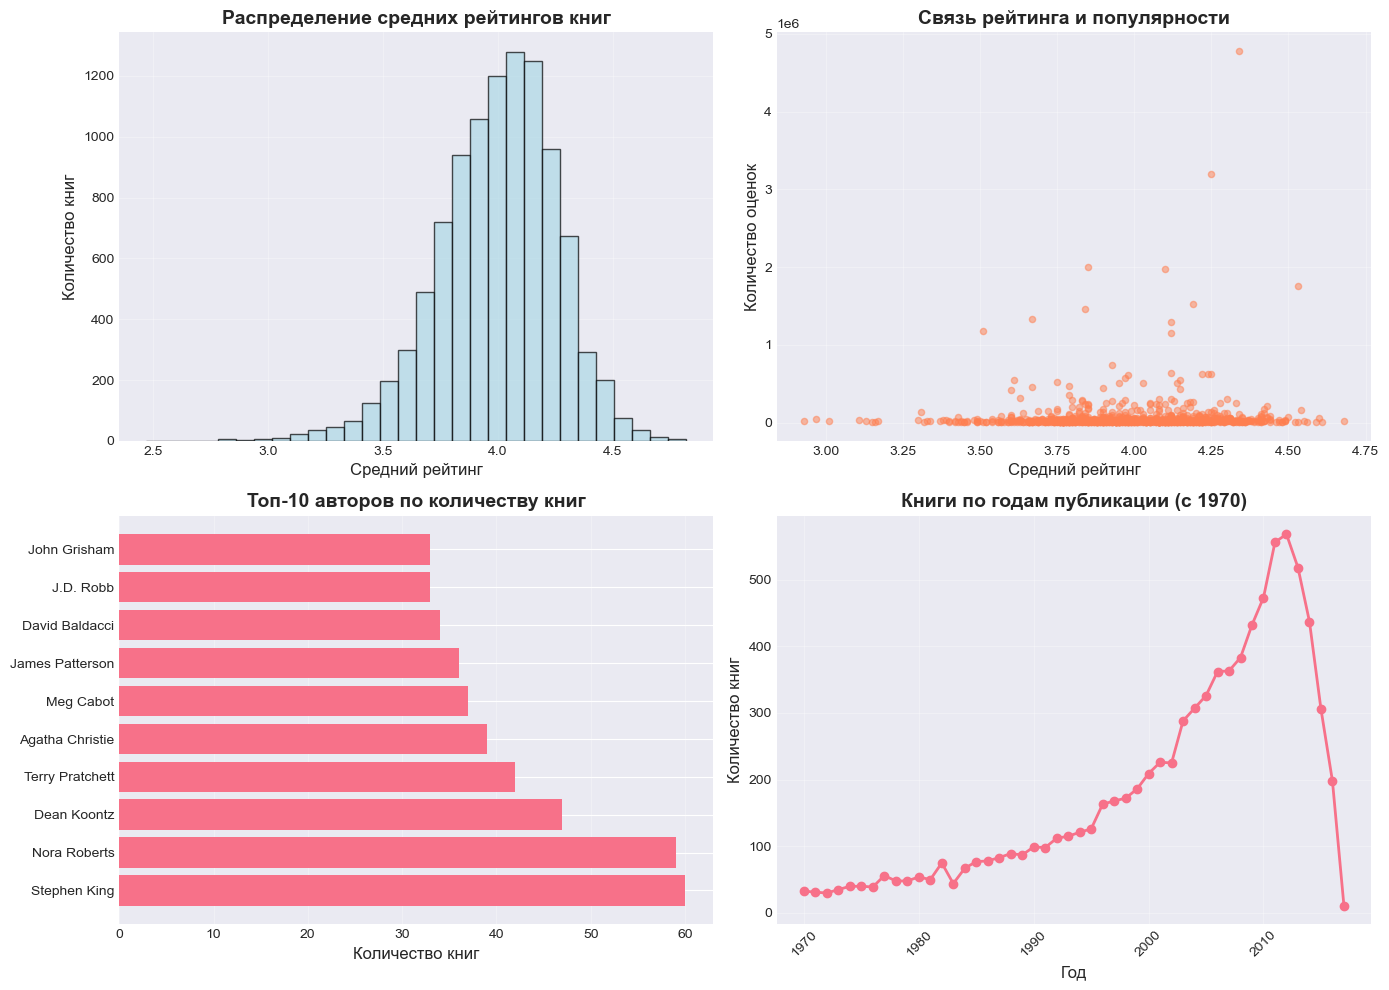

In [11]:
# === ЭТАП 3: ВИЗУАЛИЗАЦИЯ И АНАЛИЗ РЕЗУЛЬТАТОВ ===
print("\n" + "=" * 80)
print("ЭТАП 3: ВИЗУАЛИЗАЦИЯ И АНАЛИЗ РЕЗУЛЬТАТОВ")
print("=" * 80)

# 3.1 Визуализация распределения рейтингов
plt.figure(figsize=(14, 10))

# График 1: Распределение средних рейтингов книг
plt.subplot(2, 2, 1)
plt.hist(books_main['average_rating'].dropna(), bins=30, edgecolor='black', alpha=0.7, color='lightblue')
plt.title('Распределение средних рейтингов книг', fontsize=14, fontweight='bold')
plt.xlabel('Средний рейтинг', fontsize=12)
plt.ylabel('Количество книг', fontsize=12)
plt.grid(alpha=0.3)

# График 2: Связь рейтинга и количества оценок
plt.subplot(2, 2, 2)
sample_books = books_main.sample(min(1000, len(books_main)), random_state=42)
plt.scatter(sample_books['average_rating'], sample_books['ratings_count'], 
            alpha=0.5, s=20, color='coral')
plt.title('Связь рейтинга и популярности', fontsize=14, fontweight='bold')
plt.xlabel('Средний рейтинг', fontsize=12)
plt.ylabel('Количество оценок', fontsize=12)
plt.grid(alpha=0.3)

# График 3: Топ авторов по количеству книг
plt.subplot(2, 2, 3)
top_authors = books_main['authors'].value_counts().head(10)
plt.barh(range(len(top_authors)), top_authors.values)
plt.yticks(range(len(top_authors)), [a[:20] for a in top_authors.index])
plt.title('Топ-10 авторов по количеству книг', fontsize=14, fontweight='bold')
plt.xlabel('Количество книг', fontsize=12)
plt.grid(axis='x', alpha=0.3)

# График 4: Книги по годам публикации (только последние 50 лет)
plt.subplot(2, 2, 4)
recent_books = books_main[books_main['original_publication_year'] >= 1970]
year_counts = recent_books['original_publication_year'].value_counts().sort_index()
plt.plot(year_counts.index, year_counts.values, marker='o', linewidth=2)
plt.title('Книги по годам публикации (с 1970)', fontsize=14, fontweight='bold')
plt.xlabel('Год', fontsize=12)
plt.ylabel('Количество книг', fontsize=12)
plt.grid(alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## 3.2 Сравнение методов рекомендаций


СРАВНЕНИЕ МЕТОДОВ РЕКОМЕНДАЦИЙ
----------------------------------------
Ищем книги, похожие на: 'The Hunger Games (The Hunger Games, #1)'
Автор: Suzanne Collins
Ищем книги, похожие на: 'The Hunger Games (The Hunger Games, #1)'
Автор: Suzanne Collins
Ищем книги, похожие на: 'Harry Potter and the Sorcerer's Stone (Harry Potter, #1)'
Автор: J.K. Rowling, Mary GrandPré
Ищем книги, похожие на: 'Harry Potter and the Sorcerer's Stone (Harry Potter, #1)'
Автор: J.K. Rowling, Mary GrandPré
Ищем книги, похожие на: 'Twilight (Twilight, #1)'
Автор: Stephenie Meyer
Ищем книги, похожие на: 'Twilight (Twilight, #1)'
Автор: Stephenie Meyer
Средние показатели по методам рекомендаций:
         count  avg_rating
method                    
content    5.0       4.125
hybrid     5.0       0.910
popular    5.0       4.434


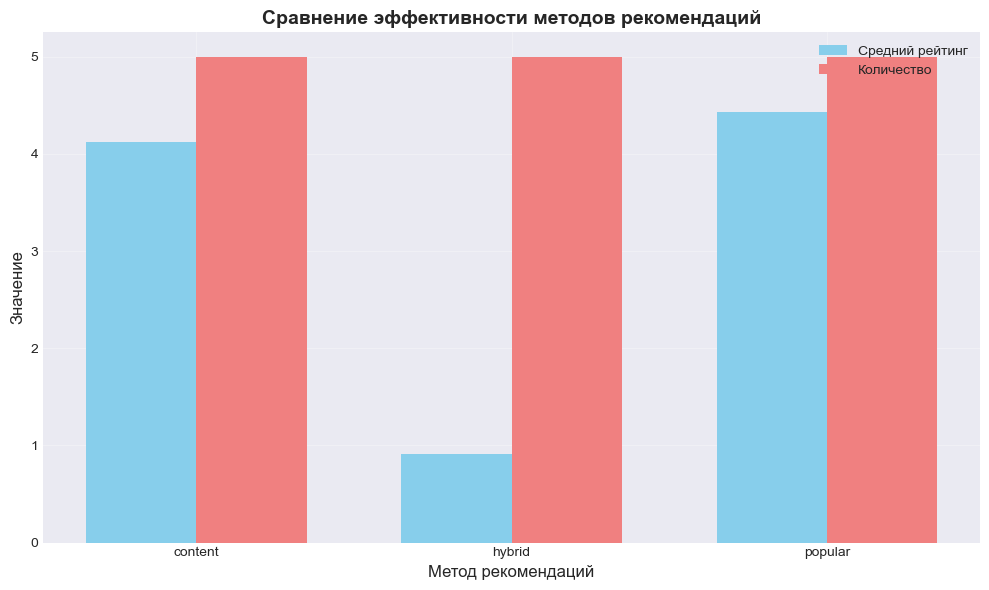

In [12]:
# 3.2 Сравнение методов рекомендаций
print("\nСРАВНЕНИЕ МЕТОДОВ РЕКОМЕНДАЦИЙ")
print("-" * 40)

# Собираем рекомендации разными методами
methods_comparison = []

# Тестовые данные
test_books = ["The Hunger Games", "Harry Potter", "Twilight"]

for book_title in test_books:
    # Популярные рекомендации
    pop_recs = get_popular_recommendations(5, 50)
    methods_comparison.append({
        'method': 'popular',
        'test_book': book_title,
        'count': len(pop_recs),
        'avg_rating': pop_recs['average_rating'].mean() if not pop_recs.empty else 0
    })
    
    # Контентные рекомендации
    content_recs = get_content_recommendations(book_title, 5)
    if content_recs is not None:
        methods_comparison.append({
            'method': 'content',
            'test_book': book_title,
            'count': len(content_recs),
            'avg_rating': content_recs['average_rating'].mean() if not content_recs.empty else 0
        })
    
    # Гибридные рекомендации
    hybrid_recs = hybrid_recommendations(book_title=book_title, n=5)
    methods_comparison.append({
        'method': 'hybrid',
        'test_book': book_title,
        'count': len(hybrid_recs),
        'avg_rating': hybrid_recs['score'].mean() if not hybrid_recs.empty else 0
    })

# Создаем DataFrame для сравнения
comparison_df = pd.DataFrame(methods_comparison)
if not comparison_df.empty:
    print("Средние показатели по методам рекомендаций:")
    method_stats = comparison_df.groupby('method').agg({
        'count': 'mean',
        'avg_rating': 'mean'
    }).round(3)
    print(method_stats.to_string())
    
    # Визуализация сравнения
    plt.figure(figsize=(10, 6))
    
    x = range(len(method_stats))
    width = 0.35
    
    plt.bar(x, method_stats['avg_rating'], width, label='Средний рейтинг', color='skyblue')
    plt.bar([i + width for i in x], method_stats['count'], width, label='Количество', color='lightcoral')
    
    plt.xlabel('Метод рекомендаций', fontsize=12)
    plt.ylabel('Значение', fontsize=12)
    plt.title('Сравнение эффективности методов рекомендаций', fontsize=14, fontweight='bold')
    plt.xticks([i + width/2 for i in x], method_stats.index)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()